# Cashflow Engine Overview

The Cashflow Engine is a financial forecasting tool designed to project the balances of term deposit products for customers over a specified time period. It utilizes a combination of classification algorithms and regression models, incorporating both internal and external variables to make accurate predictions.

---
## Key Features
---

- Cascading models: Combines classification and regression models for precise balance predictions.
- Utilizes both internal and external factors for enhanced accuracy.
- Scalable: Can be applied to a larger dataset of customers with minimal adjustments.
- Customizable: External variables can be tailored to suit specific market conditions.

**Note:** This Cashflow Engine serves as a foundational framework and can be extended or modified based on specific business requirements and additional data sources.

---
## Key Steps
---

#### __STEP 1: LOAD THE MODULES__

In [1]:
# Importing the Pandas library for data manipulation and analysis
import pandas as pd
# Importing the NumPy library for numerical computations and array processing
import numpy as np
# Importing the DecisionTreeClassifier class from scikit-learn for implementing a classification algorithm based on decision trees
from sklearn.tree import DecisionTreeClassifier
# Importing the LinearRegression class from scikit-learn for training a linear regression model
from sklearn.linear_model import LinearRegression
# Importing the warnings module to handle warnings during code execution
import warnings
# Importing the matplotlib library for creating various types of plots and visualizations
import matplotlib.pyplot as plt
# Importing the seaborn library for creating aesthetically pleasing and informative statistical graphics, enhancing visual presentation
import seaborn as sns

#### __STEP 2: LOAD THE DATA__
> This data is an example data created for illustrative purposes. It contains information about the customers who subscribe to the term desposit product

> This dataset includes various features like Initial Deposit, Interest Rate, Days to Maturity, Customer Age, Customer Income, and external factors like GDP, Unemployment Rate, S&P 500 Index, Exchange Rate, and COVID-19 Cases.

In [2]:
# Step 1: Load the data
df = pd.read_excel('Term_Deposit_Data.xlsx')

In [3]:
df.head(5)

,Initial_Deposit,Interest_Rate,Days_to_Maturity,Customer_Age,Customer_Income,GDP_Trillion,Unemployment_Rate,S&P_500_Index,Exchange_Rate,COVID_Cases,Withdrawal_Predict
0,33720,0.035407,263,47,78848,3.589978,0.054074,3416.158824,1.143858,17489,Partially
1,45343,0.025533,277,31,51830,4.009621,0.051846,4404.372065,1.267304,27687,Partially
2,16637,0.043560,278,44,71674,4.802465,0.058959,3695.613911,1.244070,4176,No_Withdrawal
3,40280,0.045619,103,43,52437,5.243427,0.039263,4278.433434,1.110298,22203,Fully
4,54566,0.034827,215,26,41323,4.979104,0.049744,3319.151055,1.224654,45548,No_Withdrawal


#### __STEP 2: CLASSIFICATION ALGORITHM (DECISION TREES)__
> A Decision Tree Classifier is employed to categorize customers into one of three withdrawal categories for the next month:
> - Full Withdrawal,
> - Partial Withdrawal, or
> - No Withdrawal.

In [4]:
# Step 2: Classification Algorithm
X = df[['Initial_Deposit', 'Interest_Rate', 'Days_to_Maturity', 'Customer_Age',
        'Customer_Income', 'GDP_Trillion', 'Unemployment_Rate', 'S&P_500_Index', 'Exchange_Rate', 'COVID_Cases']]
y = df['Withdrawal_Predict']

classifier = DecisionTreeClassifier()
classifier.fit(X, y)


DecisionTreeClassifier()

#### __STEP 3: BALANCE PREDICTION__
> For each customer, based on their withdrawal category, the balance for the next month is predicted using the following rules:
> - If fully withdrawn, the balance for the next month is set to zero.
> - If no withdrawal, the balance remains the same as the current month.
> - If partially withdrawn, a Linear Regression model is used to estimate the new balance, considering various factors like Initial Deposit, S&P 500 Index, Exchange Rate, COVID-19 Cases, Days to Maturity, GDP, Interest Rate, Customer Income, and Unemployment Rate.

In [5]:
# Step 3: Balance Prediction
def predict_balance(row):
    if row['Withdrawal_Predict'] == 'Fully':
        return 0
    elif row['Withdrawal_Predict'] == 'No_Withdrawal':
        return row['Initial_Deposit']
    else:
        X_reg = np.array(row[['Initial_Deposit', 'S&P_500_Index', 'Exchange_Rate', 'COVID_Cases', 'Days_to_Maturity',
                              'GDP_Trillion', 'Interest_Rate', 'Customer_Income', 'Unemployment_Rate']]).reshape(1, -1)
        return row['Initial_Deposit'] - regressor.predict(X_reg)[0]

#### __STEP 4: REGRESSION MODEL (LINEAR REGRESSION)__
> A Linear Regression model is trained specifically for customers who fall into the "Partially Withdrawn" category.

> This model refines the balance prediction by reducing the mean squared error.

In [6]:
# Train regression model for partial withdrawals
partial_withdrawals = df[df['Withdrawal_Predict'] == 'Partially']
X_reg = partial_withdrawals[['Initial_Deposit', 'S&P_500_Index', 'Exchange_Rate', 'COVID_Cases', 'Days_to_Maturity',
                             'GDP_Trillion', 'Interest_Rate', 'Customer_Income', 'Unemployment_Rate']]
y_reg = partial_withdrawals['Initial_Deposit'] - partial_withdrawals['Initial_Deposit'] * 0.2  # Assuming 20% withdrawal
regressor = LinearRegression()
regressor.fit(X_reg, y_reg)


LinearRegression()

#### __STEP 5: BALANCE FORECASTING__
> The engine projects the overall balance for the term deposit product over the next 12 months, considering the predicted balances for each customer.

In [7]:
# Ignore all warnings
warnings.filterwarnings("ignore")

# Set display options for floats
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# Generate predictions for the next 12 months
balances_by_month = []

# Add initial deposit as "Month_0"
df_initial_deposit = df['Initial_Deposit'].copy()

for month in range(1, 13):
    next_month_balances = []

    for index, row in df.iterrows():
        if row['Withdrawal_Predict'] == 'Partially':
            X_reg = np.array(row[['Initial_Deposit', 'S&P_500_Index', 'Exchange_Rate', 'COVID_Cases', 'Days_to_Maturity',
                                  'GDP_Trillion', 'Interest_Rate', 'Customer_Income', 'Unemployment_Rate']]).reshape(1, -1)
            partial_withdrawal = row['Initial_Deposit'] - regressor.predict(X_reg)[0]
            next_month_balances.append(max(partial_withdrawal, 0))  # Ensure balance is not negative
        else:
            next_month_balances.append(max(predict_balance(row), 0))  # Ensure balance is not negative

    # Add the next month balances to the DataFrame
    df['Next_Month_Balance'] = next_month_balances

    # Update Initial_Deposit for the next month
    df['Initial_Deposit'] = df['Next_Month_Balance']

    # Reset the Withdrawal_Predict column
    df['Withdrawal_Predict'] = classifier.predict(df[X.columns])

    # Save the balances for this month
    balances_by_month.append(next_month_balances.copy())

    # Clear Next_Month_Balance for the next iteration
    next_month_balances = []


In [8]:
# Convert the balances by month into a DataFrame and transpose
df_balances_by_month = pd.DataFrame(balances_by_month).T
df_balances_by_month.columns = [f'Month_{i}' for i in range(2, 14)]

# Concatenate side by side
df_balances_by_month_ = pd.concat([df_initial_deposit, df_balances_by_month], axis=1)

#### __STEP 5.a: RESULTS: BALANCES BY MONTH__
> The results are presented in the dataframe, displaying the balances for each subsequent months.

> Note that the balances keep decreasing over time

In [9]:
print("\nBalances by Month:")
df_balances_by_month_


Balances by Month:


,Initial_Deposit,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12,Month_13
0,33720,6744.00,1348.80,269.76,53.95,10.79,2.16,0.43,0.09,0.02,0.00,0.00,0.00
1,45343,9068.60,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,16637,16637.00,16637.00,16637.00,16637.00,16637.00,16637.00,16637.00,16637.00,16637.00,16637.00,16637.00,16637.00
3,40280,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,54566,54566.00,54566.00,54566.00,54566.00,54566.00,54566.00,54566.00,54566.00,54566.00,54566.00,54566.00,54566.00
5,41019,41019.00,41019.00,41019.00,41019.00,41019.00,41019.00,41019.00,41019.00,41019.00,41019.00,41019.00,41019.00
6,28898,28898.00,28898.00,28898.00,28898.00,28898.00,28898.00,28898.00,28898.00,28898.00,28898.00,28898.00,28898.00
7,43867,43867.00,43867.00,43867.00,43867.00,43867.00,43867.00,43867.00,43867.00,43867.00,43867.00,43867.00,43867.00
8,24696,24696.00,24696.00,24696.00,24696.00,24696.00,24696.00,24696.00,24696.00,24696.00,24696.00,24696.00,24696.00
9,54295,10859.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


#### __STEP 5.b: RESULTS: OVERALL BALANCES__
> The results showcase the balances for each month and their respective percentage differences.

> It is important to note that the percentage differences gradually decrease over time, following a saturation curve characteristic. This demonstrates that individuals who are more influenced by internal and external factors tend to withdraw their amount over time.

> Additionally, there are customers who may complete the maturity period and withdraw the amount, which can vary depending on the contractual duration.

In [10]:
import pandas as pd

# Assuming df_balances_by_month_ is your DataFrame

# Calculate initial balance
initial_balance = df_balances_by_month_['Initial_Deposit'].iloc[0]

# Calculate the sum of each month's balance, including the initial deposit
sum_by_month = df_balances_by_month_.sum()

# Create a new DataFrame to display the results
result_df = pd.DataFrame({
    'Month': sum_by_month.index,
    'Total_Balance': sum_by_month.values
})

# Calculate the percentage difference
result_df['Percentage_Difference'] = result_df['Total_Balance'].pct_change() * 100

result_df


,Month,Total_Balance,Percentage_Difference
0,Initial_Deposit,757825.00,NaN
1,Month_2,444554.00,-41.34
2,Month_3,391766.04,-11.87
3,Month_4,386922.01,-1.24
4,Month_5,385953.20,-0.25
5,Month_6,385759.44,-0.05
6,Month_7,385720.69,-0.01
7,Month_8,385712.94,-0.00
8,Month_9,385711.39,-0.00
9,Month_10,385711.08,-0.00


#### __STEP 7: VISUALIZATION__
> The results are presented visually in a bar chart, displaying the Total Balance and Percentage Difference over the months.

posx and posy should be finite values
posx and posy should be finite values


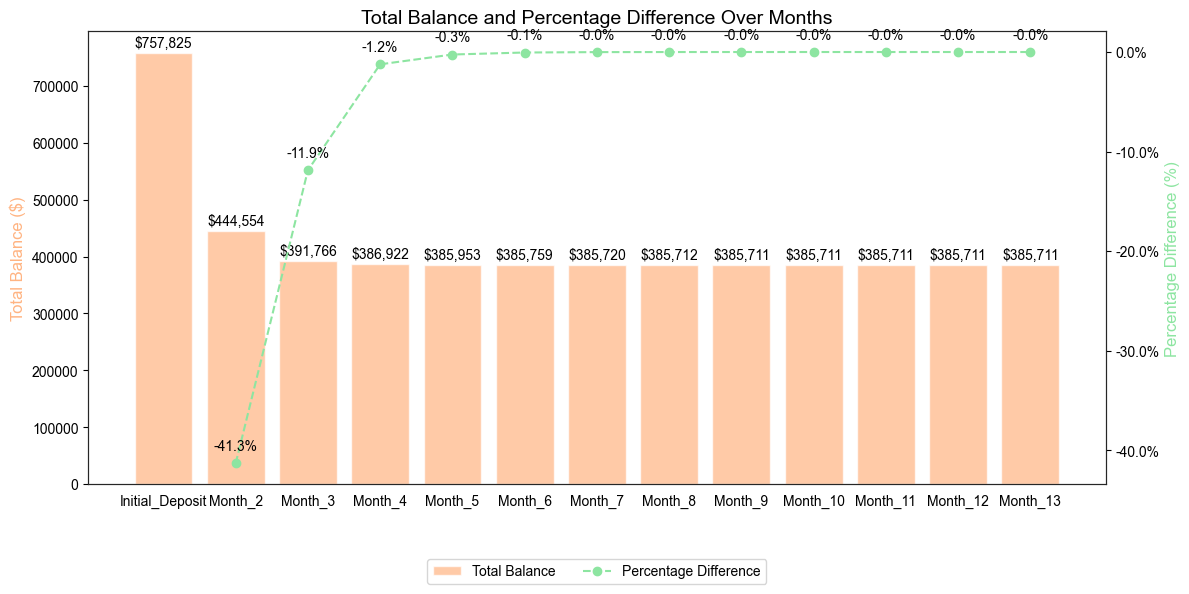

In [11]:
# Ignore all warnings
warnings.filterwarnings("ignore")

# Set style with seaborn and remove grid
sns.set_style("white")

# Assuming result_df is your DataFrame

# Create figure and axis with increased figure size and margins
fig, ax1 = plt.subplots(figsize=(12, 6))
# Adjust margins and padding
plt.subplots_adjust(left=0.1, right=0.9, top=0.95, bottom=0.25)  # Adjust margins and padding

# Bar plot for Total Balance with data labels
bars = ax1.bar(result_df['Month'], result_df['Total_Balance'], color=sns.color_palette("pastel")[1], label='Total Balance', alpha=0.7)
ax1.set_xlabel('Month', fontsize=12, color='black')  # Set x-axis label font size and color
ax1.set_xlabel('')  # Remove x-axis label
ax1.set_ylabel('Total Balance ($)', fontsize=12, color=sns.color_palette("pastel")[1])  # Add $ sign

# Add data labels with $ sign, without decimal places
for bar in bars:
    yval = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2, yval + 5000, f'${int(yval):,}', ha='center', va='bottom', fontsize=10, color='black')  # Adjust data label position

# Create a secondary y-axis
ax2 = ax1.twinx()

# Line plot for Percentage Difference with data labels
line = ax2.plot(result_df['Month'], result_df['Percentage_Difference'], color=sns.color_palette("pastel")[2], label='Percentage Difference', marker='o', linestyle='dashed')
ax2.set_ylabel('Percentage Difference (%)', fontsize=12, color=sns.color_palette("pastel")[2])

# Add % sign to y-axis ticks
vals = ax2.get_yticks()
ax2.set_yticklabels(['{:,.1f}%'.format(val) for val in vals])

# Add data labels for Percentage Difference with one decimal place
for i, val in enumerate(result_df['Percentage_Difference']):
    ax2.text(i, val + 1, f'{val:.1f}%', ha='center', va='bottom', fontsize=10, color='black')  # Adjust data label position

# Set titles for both axes
ax1.set_title('Total Balance and Percentage Difference Over Months', fontsize=14, color='black')  # Set title font size and color

# Set font size for axis labels
ax1.tick_params(axis='both', labelsize=10, colors='black')  # Set axis label font size and color
ax2.tick_params(axis='both', labelsize=10, colors='black')  # Set axis label font size and color

# Set primary axis title
ax1.set_ylabel('Total Balance ($)', fontsize=12, color=sns.color_palette("pastel")[1])  # Add $ sign

# Set secondary axis title
ax2.set_ylabel('Percentage Difference (%)', fontsize=12, color=sns.color_palette("pastel")[2])

# Manually set title colors
ax1.title.set_color('black')
ax2.title.set_color('black')

# Set legend for both axes outside the grid
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2, labelcolor='black')  # Set legend text color to black

# Adjust layout to prevent overlap
fig.tight_layout()

# Display the plot
plt.show()
